# [NCTS] 期末專題

### 組員：辜宥郡、辜莉婷

# 題目：

### Tensor flow 機器學習 - 比較CNN卷積神經網路與MLP多層感知器 - 壓力床墊之圖片辨識

# 專案目的：

### 現在台灣社會呈現高齡化，因此長照的需求也跟著提升。                                                                                                所謂長照就是照顧長期臥在病床上的人，因此此床墊的其中一個目的就是監控病人的姿勢、壓力分佈、照顧者是否有定時幫病人進行翻身的動作。

# 做法：

### 利用 Tensorflow 建立 CNN 卷積網路模型，同時也建立 MLP 模型，使用壓力感測床墊的壓力分佈圖來進行訓練，而後對新資料進行姿勢辨識，並且對兩者進行比較。
### 而在最後希望在建立完資料庫的模型後，能進行即時辨識，就能夠實現即時監控。


## Input：壓力床墊輸出的壓力分佈圖

## Output：利用訓練後的測試結果形成混淆矩陣(Confusion Matrix)

# DATABASE 整理：

圖片大小為9*7，下圖為收取床墊資料的app
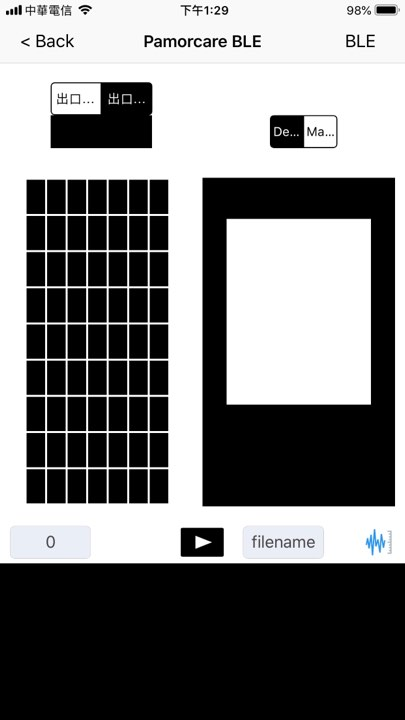

從app輸出的原始資料為txt文字檔，如下圖
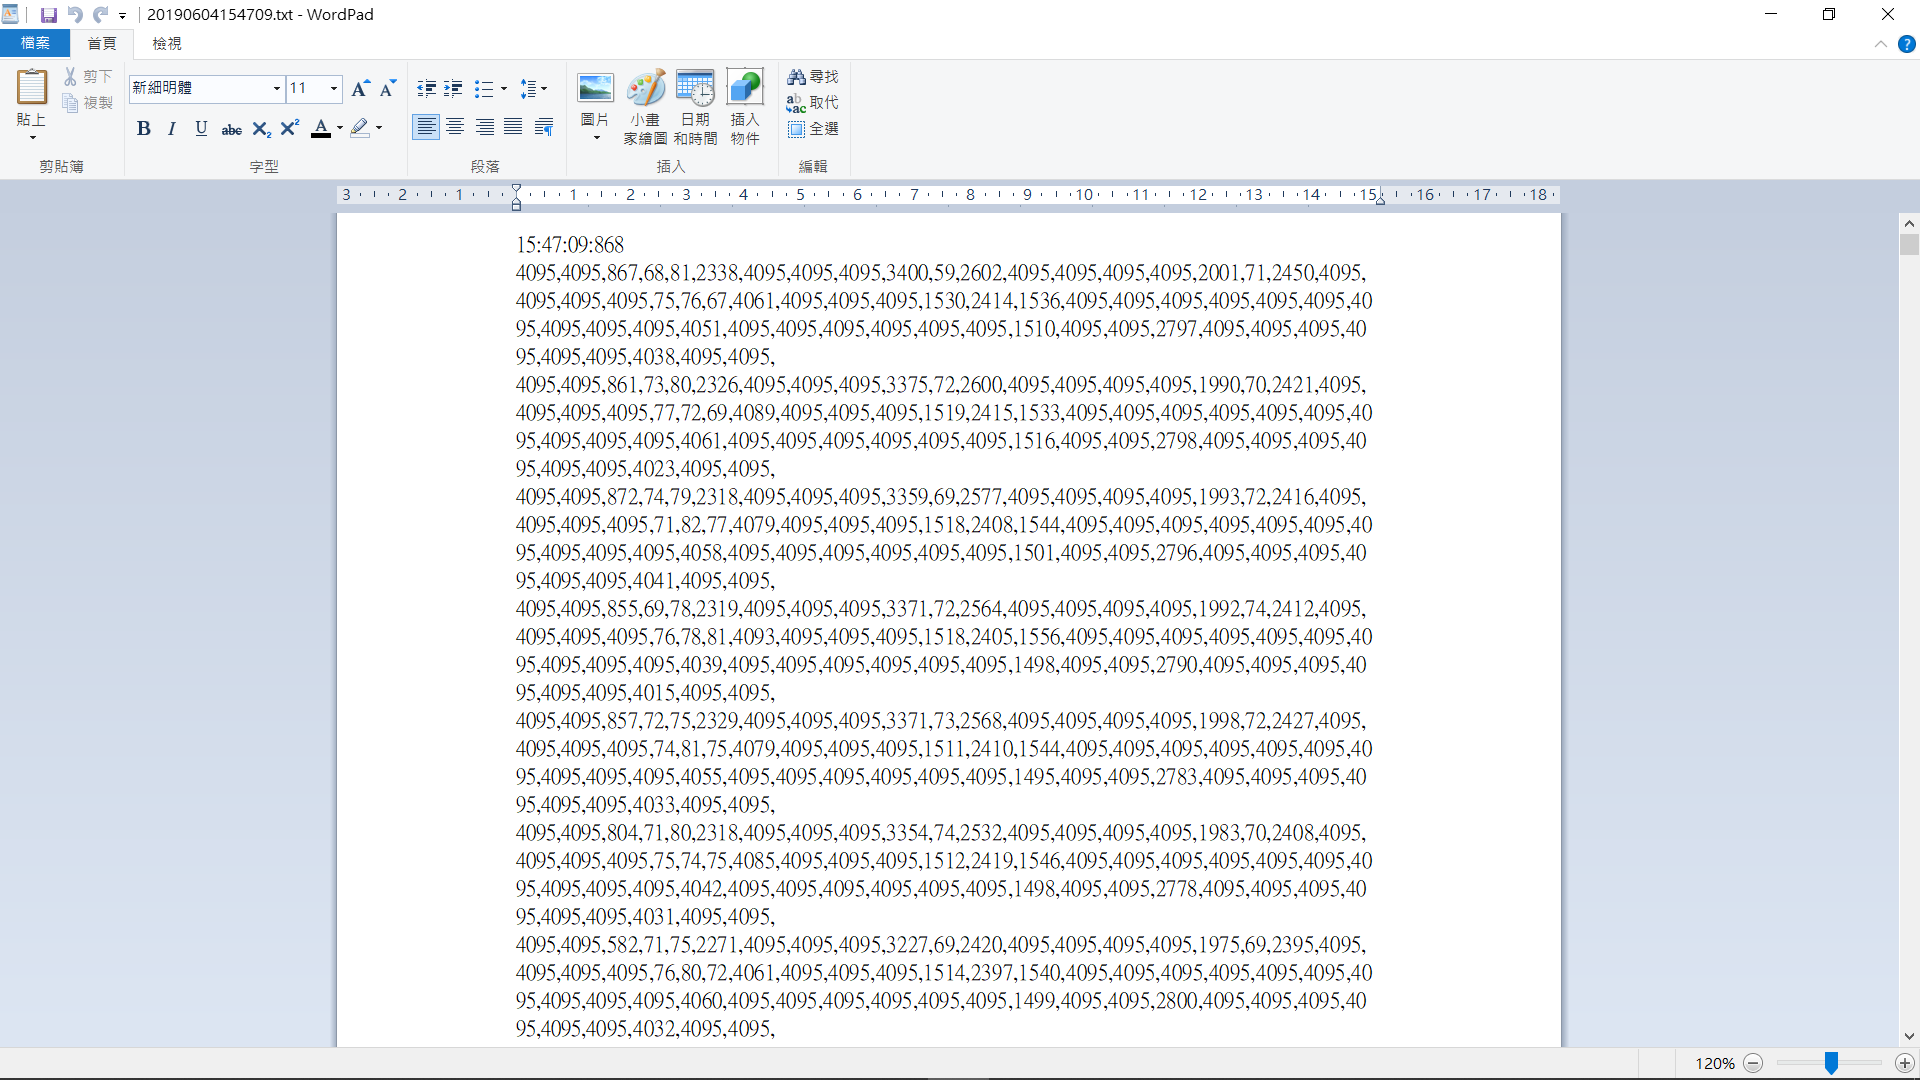
63個數字為一張圖片，4095為壓力值最小，0為壓力值最大

### 為了公平性，兩者使用的 dataframe 要完全一樣，因此先將原始的 txt 整理為 excel，在進行標籤的分類時就取用 excel 整理好的 database 來分。
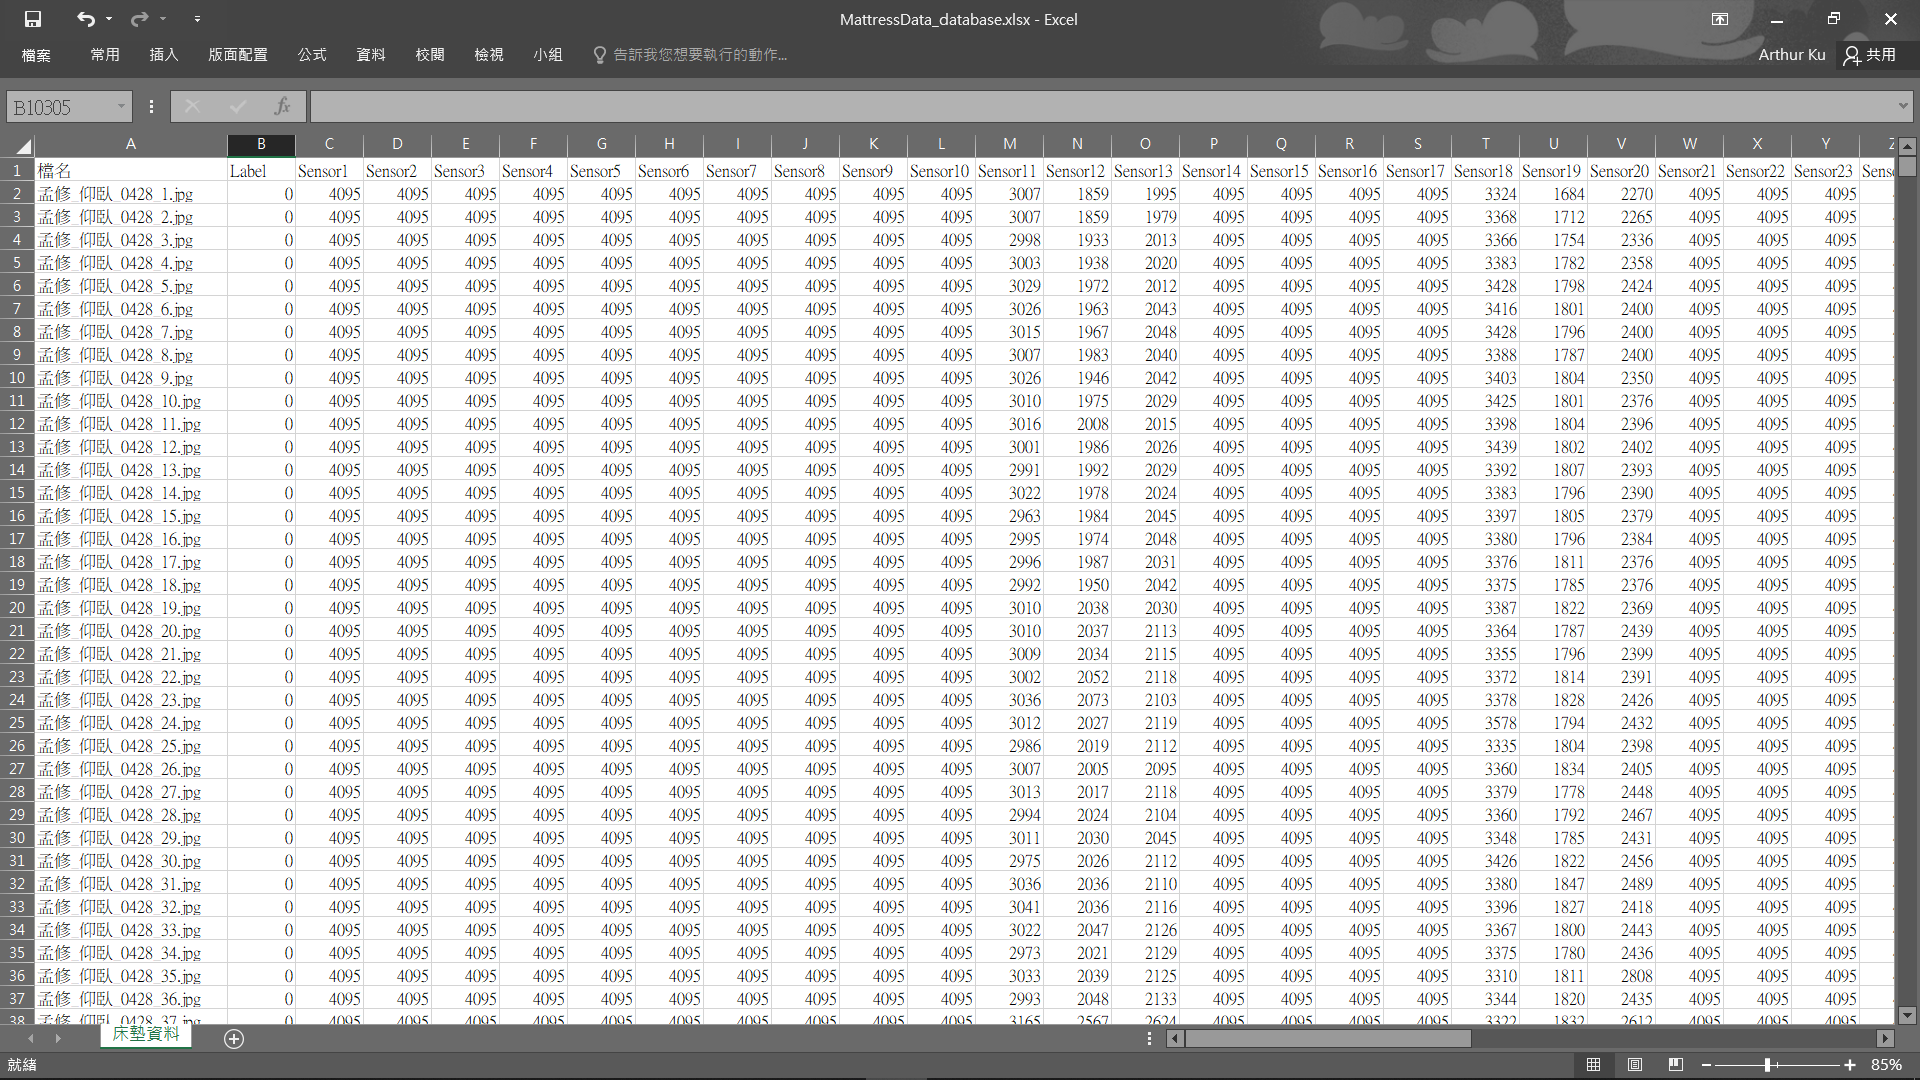

### 要使用CNN，需要原始資料轉成圖片，為了製成灰階圖，我們額外用C語言，利用內插法將原始txt、壓力值0~4095、大小為 63 pixel，轉換為256灰階(256 gray level)、大小為 310*260 pixel。
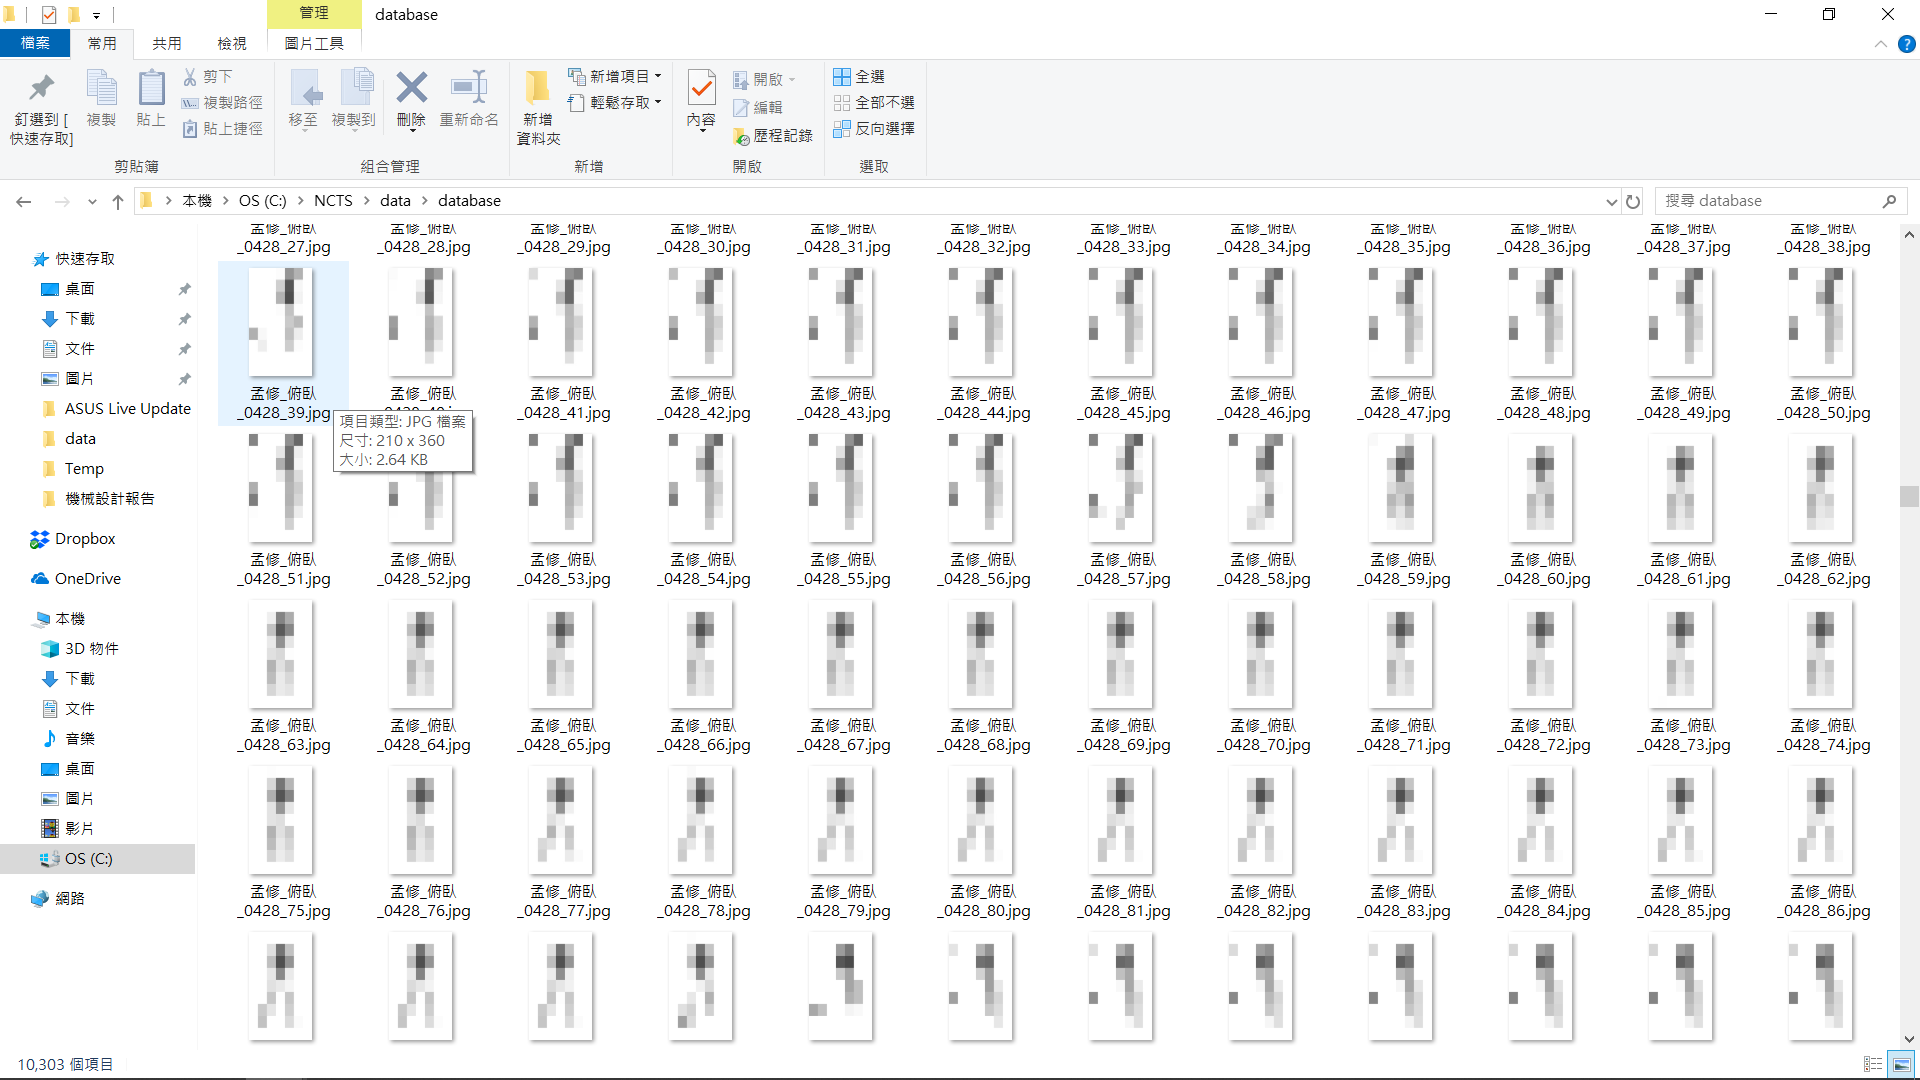

# 整體程式架構： 

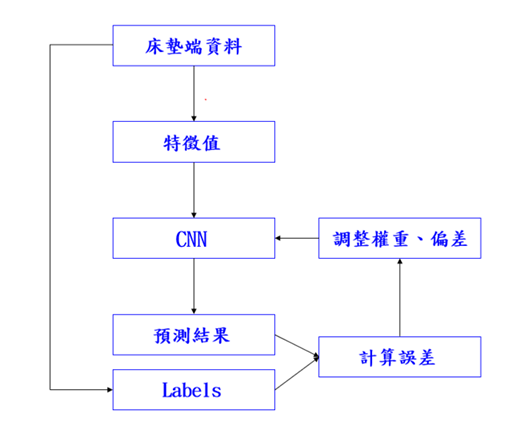

# 姿勢分類：
## 分為五種

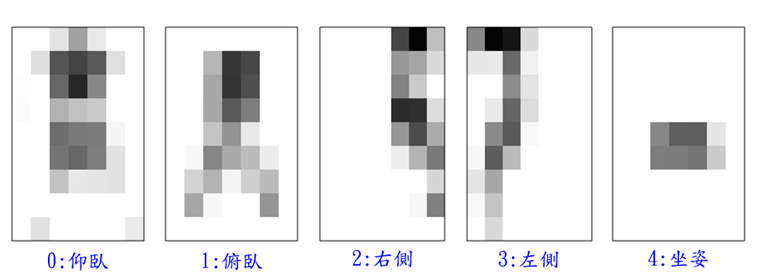

# 我們 CNN 模型的架構：

包含各有兩層的卷積層及池化層，使用的激活函數為"relu"，最後使用大小為64的全連接層來提高模型的非線性表達能力，再用因為分類數為5，所以大小為5的輸出層，經過softmax函數來輸出辨識結果

# MLP 模型架構：

建立數目為63的輸入神經元(因為圖片資料位元大小為9*7)，連接數目40、激活函數為"relu"的第一層隱藏層，再連接數目20、同樣是"relu"第二層隱藏層，最後經過softmax函數來輸出辨識結果。

# 程式碼開始

# Preprocess Dataframes

In [1]:
import os  # 處理檔案路徑
import glob  #查詢資料夾與文件

#keras 模組
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.utils import np_utils, generic_utils

#載入檔案使用
from PIL import Image
import numpy as np
from six.moves import range
import pandas as pd

#資料前處理
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

C:\Users\SPLab1080\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
config = tf.ConfigProto(allow_soft_placement=True)

#最多佔gpu資源的70%
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

#按需增加gpu資源
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
all_df = pd.read_excel("C:/data/MattressData_database.xlsx")

In [4]:
num=len(all_df)
num

10303

In [5]:
def data_sep(df,prop):
    train_df,test_df=train_test_split(df,train_size=prop,random_state=0) 
    return train_df,test_df

In [6]:
def sep_train_test(df,prop):
    df_label0=df.loc[df['Label']==0]
    train_df_label0,test_df_label0=data_sep(df_label0,prop)
    df_label1=df.loc[df['Label']==1]
    train_df_label1,test_df_label1=data_sep(df_label1,prop)
    df_label2=df.loc[df['Label']==2]
    train_df_label2,test_df_label2=data_sep(df_label2,prop)
    df_label3=df.loc[df['Label']==3]
    train_df_label3,test_df_label3=data_sep(df_label3,prop)
    df_label4=df.loc[df['Label']==4]
    train_df_label4,test_df_label4=data_sep(df_label4,prop)
    train_frames = [train_df_label0, train_df_label1, train_df_label2,train_df_label3,train_df_label4]
    train_df=pd.concat(train_frames)
    test_frames=[test_df_label0,test_df_label1,test_df_label2,test_df_label3,test_df_label4]
    test_df=pd.concat(test_frames)
    return train_df,test_df

In [7]:
train_df,test_df=sep_train_test(all_df,0.8)

C:\Users\SPLab1080\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
def read_to_arr_cnn(raw_df):
    
    imgs=raw_df['檔名']
    imgs=imgs.to_numpy()
    label=raw_df['Label']
    label=label.values
    num = len(imgs)
    data_cnn = np.empty((num,360,210,1),dtype="float32")

    for i in range(num):
            
        img = Image.open("C:/data/database/" + imgs[i])
        arr = np.asarray(img, dtype="float32")
        arr.resize((360, 210, 1))
        data_cnn[i, :, :, :] = arr
    
    data_normalize=data_cnn/255
    label_OneHot=np_utils.to_categorical(label)
    
    return data_normalize , label_OneHot

In [9]:
def read_to_arr_mlp(raw_df):
    df=raw_df.drop(['檔名'], axis=1)

    ndarray = df.values
    Label = ndarray[:,0]
    Features = ndarray[:,1:]

    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaledFeatures=minmax_scale.fit_transform(Features)
    
    Label_OneHot=np_utils.to_categorical(Label)
    
    return scaledFeatures,Label_OneHot

In [10]:
train_features_mlp,train_label_mlp=read_to_arr_mlp(train_df)
test_features_mlp,test_label_mlp=read_to_arr_mlp(test_df)
train_features_cnn,train_label_cnn=read_to_arr_cnn(train_df)
test_features_cnn,test_label_cnn=read_to_arr_cnn(test_df)

C:\Users\SPLab1080\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Create Model

In [11]:
#CNN model

model_cnn = Sequential()
#卷積層1
model_cnn.add(Conv2D(filters=16,
                 kernel_size=(5,5),
                 padding='same',
                 input_shape=(360,210,1), 
                 activation='relu'))
#池化層1
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#卷積層2
model_cnn.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu'))
#池化層2
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
#平坦層
model_cnn.add(Flatten())
#全連接層
model_cnn.add(Dense(64, activation='relu'))
#輸出層
model_cnn.add(Dense(5,activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
#MLP model
model_mlp = Sequential()
model_mlp.add(Dense(units=40, input_dim=63, 
                kernel_initializer='normal', 
                activation='relu'))
model_mlp.add(Dense(units=20, 
                kernel_initializer='normal', 
                activation='relu'))
model_mlp.add(Dense(units=5, 
                kernel_initializer='normal',
                activation='softmax'))

# Train Model

In [13]:
#CNN training
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy']) 
train_history_cnn=model_cnn.fit(x=train_features_cnn, 
                        y=train_label_cnn,validation_split=0, 
                        epochs=20, batch_size=16,verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 12s - loss: 0.7617 - acc: 0.7321
Epoch 2/20
 - 11s - loss: 0.0497 - acc: 0.9882
Epoch 3/20
 - 11s - loss: 0.0360 - acc: 0.9905
Epoch 4/20
 - 11s - loss: 0.0227 - acc: 0.9942
Epoch 5/20
 - 11s - loss: 0.0270 - acc: 0.9922
Epoch 6/20
 - 11s - loss: 0.0113 - acc: 0.9968
Epoch 7/20
 - 11s - loss: 0.0715 - acc: 0.9811
Epoch 8/20
 - 11s - loss: 0.1040 - acc: 0.9735
Epoch 9/20
 - 11s - loss: 0.0468 - acc: 0.9869
Epoch 10/20
 - 11s - loss: 0.0081 - acc: 0.9978
Epoch 11/20
 - 11s - loss: 0.0080 - acc: 0.9978
Epoch 12/20
 - 11s - loss: 0.0053 - acc: 0.9988
Epoch 13/20
 - 11s - loss: 0.0031 - acc: 0.9992
Epoch 14/20
 - 11s - loss: 0.0027 - acc: 0.9992
Epoch 15/20
 - 11s - loss: 3.6700e-04 - acc: 1.0000
Epoch 16/20
 - 11s - loss: 1.0486e-04 - acc: 1.0000
Epoch 17/20
 - 11s - loss: 6.0245e-05 - acc: 1.0000
Epoch 18/20
 - 11s - loss: 3.4542e-05 - acc: 1.0000
Epoch 19/20
 - 11s - loss: 2.0097e-05 - acc: 1.0000
Epoch 20/20
 - 11s - loss: 4.

In [14]:
#MLP training
model_mlp.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
train_history_mlp =model_mlp.fit(x=train_features_mlp, 
                         y=train_label_mlp, 
                         validation_split=0, 
                         epochs=200, 
                         batch_size=64,verbose=2)

Epoch 1/200
 - 1s - loss: 0.4870 - acc: 0.8000
Epoch 2/200
 - 0s - loss: 0.4087 - acc: 0.8083
Epoch 3/200
 - 0s - loss: 0.3473 - acc: 0.8487
Epoch 4/200
 - 0s - loss: 0.2851 - acc: 0.8817
Epoch 5/200
 - 0s - loss: 0.2391 - acc: 0.9066
Epoch 6/200
 - 0s - loss: 0.2113 - acc: 0.9201
Epoch 7/200
 - 0s - loss: 0.1951 - acc: 0.9247
Epoch 8/200
 - 0s - loss: 0.1813 - acc: 0.9303
Epoch 9/200
 - 0s - loss: 0.1728 - acc: 0.9343
Epoch 10/200
 - 0s - loss: 0.1649 - acc: 0.9369
Epoch 11/200
 - 0s - loss: 0.1606 - acc: 0.9381
Epoch 12/200
 - 0s - loss: 0.1532 - acc: 0.9403
Epoch 13/200
 - 0s - loss: 0.1466 - acc: 0.9440
Epoch 14/200
 - 0s - loss: 0.1429 - acc: 0.9450
Epoch 15/200
 - 0s - loss: 0.1366 - acc: 0.9482
Epoch 16/200
 - 0s - loss: 0.1328 - acc: 0.9512
Epoch 17/200
 - 0s - loss: 0.1313 - acc: 0.9498
Epoch 18/200
 - 0s - loss: 0.1253 - acc: 0.9529
Epoch 19/200
 - 0s - loss: 0.1206 - acc: 0.9551
Epoch 20/200
 - 0s - loss: 0.1197 - acc: 0.9544
Epoch 21/200
 - 0s - loss: 0.1138 - acc: 0.9583
E

Epoch 171/200
 - 0s - loss: 0.0097 - acc: 0.9972
Epoch 172/200
 - 0s - loss: 0.0086 - acc: 0.9975
Epoch 173/200
 - 0s - loss: 0.0080 - acc: 0.9976
Epoch 174/200
 - 0s - loss: 0.0080 - acc: 0.9978
Epoch 175/200
 - 0s - loss: 0.0095 - acc: 0.9976
Epoch 176/200
 - 0s - loss: 0.0076 - acc: 0.9979
Epoch 177/200
 - 0s - loss: 0.0101 - acc: 0.9973
Epoch 178/200
 - 0s - loss: 0.0075 - acc: 0.9981
Epoch 179/200
 - 0s - loss: 0.0087 - acc: 0.9976
Epoch 180/200
 - 0s - loss: 0.0072 - acc: 0.9983
Epoch 181/200
 - 0s - loss: 0.0081 - acc: 0.9981
Epoch 182/200
 - 0s - loss: 0.0102 - acc: 0.9970
Epoch 183/200
 - 0s - loss: 0.0073 - acc: 0.9979
Epoch 184/200
 - 0s - loss: 0.0101 - acc: 0.9970
Epoch 185/200
 - 0s - loss: 0.0083 - acc: 0.9975
Epoch 186/200
 - 0s - loss: 0.0086 - acc: 0.9976
Epoch 187/200
 - 0s - loss: 0.0068 - acc: 0.9981
Epoch 188/200
 - 0s - loss: 0.0096 - acc: 0.9974
Epoch 189/200
 - 0s - loss: 0.0066 - acc: 0.9982
Epoch 190/200
 - 0s - loss: 0.0066 - acc: 0.9983
Epoch 191/200
 - 0s 

In [15]:
scores_cnn = model_cnn.evaluate(test_features_cnn,test_label_cnn)
print()
print('accuracy=',scores_cnn[1])

2062/2062 [==============================] - 1s 567us/step

accuracy= 0.997090203685742


In [16]:
scores_mlp = model_mlp.evaluate(test_features_mlp,test_label_mlp)
print()
print('accuracy=',scores_mlp[1])

2062/2062 [==============================] - 0s 66us/step

accuracy= 0.9966052404083636


# Graphically display the training process

In [17]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train):
    plt.plot(train_history.history[train])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

### CNN

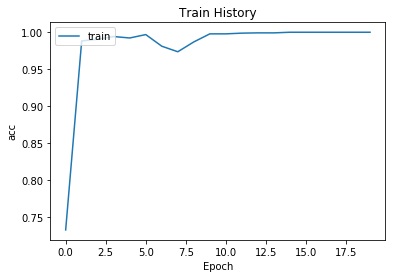

In [18]:
show_train_history(train_history_cnn,'acc')

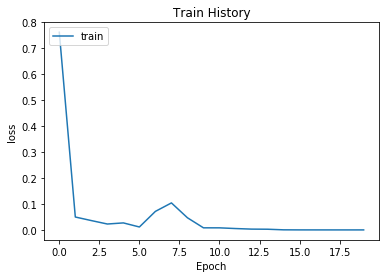

In [19]:
show_train_history(train_history_cnn,'loss')

### MLP

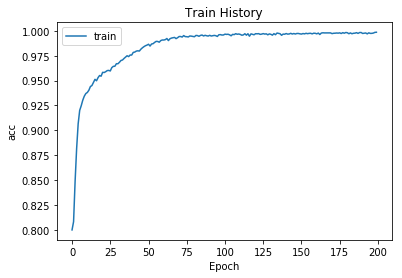

In [20]:
show_train_history(train_history_mlp,'acc')

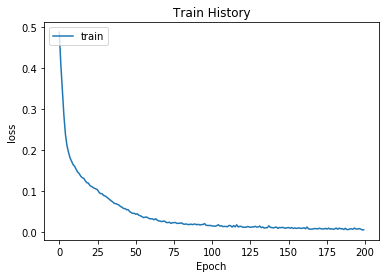

In [21]:
show_train_history(train_history_mlp,'loss')

# Confusion Matrix

In [22]:
prediction_cnn=model_cnn.predict_classes(test_features_cnn)


df=test_df.drop(['檔名'], axis=1)
test_dfarray = df.values
Label = test_dfarray[:,0]

pd.crosstab(Label,prediction_cnn,
            rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4
label,,,,,
0,335,0,0,0,0
1,0,471,0,0,0
2,0,1,364,0,1
3,1,0,1,380,0
4,0,1,1,0,506


In [23]:
prediction_mlp=model_mlp.predict_classes(test_features_mlp)


df=test_df.drop(['檔名'], axis=1)
test_dfarray = df.values
Label = test_dfarray[:,0]

pd.crosstab(Label,prediction_mlp,
            rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4
label,,,,,
0,335,0,0,0,0
1,0,470,0,0,1
2,0,3,359,2,2
3,0,3,0,376,3
4,0,2,1,0,505


# Realtime application

In [24]:
def label_to_statement(label):
    numbers = {
        0 : "仰臥",
        1 : "俯臥",
        2 : "右側",
        3 : "左側",
        4 : "坐起"
    }

    return numbers.get(label, None)

In [30]:
def predict_pose(featuresArray): 
    prediction_cnn=model_cnn.predict_classes(featuresArray)
    df=test_df.drop(['檔名'], axis=1)
    test_dfarray = df.values
    Label = test_dfarray[:,0]
    for df in prediction_cnn:
        statement=label_to_statement(df)
        print (statement)

In [31]:
predict_pose(test_features_cnn)

仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰臥
仰

# 結論

從最後輸出的混淆矩陣可以看出，CNN的辨識能力稍微比MLP還要好一些。
而在程式的最後實現了，如果將圖片輸入便能立即辨識出目前的姿勢為何。

# 可以改進的地方

原本的目標是希望能夠做到case by case，也就是用到遷移學習，但是因為時間的關係所以並沒有實作到。
還有，應該在訓練集中再分出驗證集來作訓練的驗證，查看是否過擬和或欠擬和。